In [1]:
# =============================================================================
# VJEŽBA: Napredni Feature Engineering i Prevencija Overfittinga
# DATASET: Električna vozila (Washington State)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [2]:
# 1. Učitavanje podataka direktno s interneta
url = 'https://data.wa.gov/api/views/f6w7-q2d2/rows.csv?accessType=DOWNLOAD'

print("Preuzimam podatke s wa.gov... (ovo može potrajati par sekundi)...")
data = pd.read_csv(url)

print(f"Podaci učitani. Ukupno redova: {len(data)}")


Preuzimam podatke s wa.gov... (ovo može potrajati par sekundi)...
Podaci učitani. Ukupno redova: 269673


In [5]:
# Brzo čišćenje za potrebe vježbe
# Zadržavamo samo vozila gdje je 'Electric Range' poznat (veći od 0)
# (Napomena: Mnogi novi BEV modeli u ovom datasetu imaju range 0 jer nije unesen,
# pa ih mičemo da ne zbunjuju model za regresiju)
data = data[data['Electric Range'] > 0]

print(f"Podaci nakon uklanjanja nultog dometa: {len(data)}")
print(data.head(3))


Podaci nakon uklanjanja nultog dometa: 100935
   VIN (1-10)  County     City State  Postal Code  Model Year     Make  \
0  3C3CFFGE1G  Yakima   Yakima    WA      98908.0        2016     FIAT   
1  WP0AB2Y16L    King   Auburn    WA      98092.0        2020  PORSCHE   
2  5YJ3E1EB2J    King  Seattle    WA      98109.0        2018    TESLA   

     Model           Electric Vehicle Type  \
0      500  Battery Electric Vehicle (BEV)   
1   TAYCAN  Battery Electric Vehicle (BEV)   
2  MODEL 3  Battery Electric Vehicle (BEV)   

  Clean Alternative Fuel Vehicle (CAFV) Eligibility  Electric Range  \
0           Clean Alternative Fuel Vehicle Eligible            84.0   
1           Clean Alternative Fuel Vehicle Eligible           203.0   
2           Clean Alternative Fuel Vehicle Eligible           215.0   

   Base MSRP  Legislative District  DOL Vehicle ID  \
0        0.0                  14.0       180778377   
1        0.0                  47.0       277717723   
2        0.0             

In [7]:
# =============================================================================
# DIO 1: NAPREDNI FEATURE ENGINEERING
# =============================================================================
print("\n" + "="*50)
print("DIO 1: FEATURE ENGINEERING - STVARANJE PAMETNIH PODATAKA")
print("="*50)

# --- 1. Transformacija / Izračunavanje (Age from Year) ---
# Umjesto 'Model Year' (npr. 2018), korisnije je znati starost vozila.
current_year = 2025
data['Vehicle_Age'] = current_year - data['Model Year']

print("\n1. Kreirana značajka 'Vehicle_Age':")
print(data[['Model Year', 'Vehicle_Age']].head())


# --- 2. Binning (Grupiranje) Numeričkih Značajki ---
# Grupiramo 'Electric Range' u kategorije: Kratki, Srednji, Dugi domet.
# Ovo pomaže modelu da generalizira i ignorira male razlike (npr. 215 vs 220 milja).

bins = [0, 100, 250, 1000]
labels = ['Kratki domet', 'Srednji domet', 'Dugi domet']
data['Range_Category'] = pd.cut(data['Electric Range'], bins=bins, labels=labels)

print("\n2. Kreirana značajka 'Range_Category' (Binning):")
print(data[['Electric Range', 'Range_Category']].head())


# --- 3. Interakcijske značajke (Tekstualne) ---
# Ponekad je kombinacija Marka + Model informativnija nego odvojeno.
data['Make_Model'] = data['Make'] + "_" + data['Model']

print("\n3. Kreirana značajka 'Make_Model':")
print(data[['Make', 'Model', 'Make_Model']].head())


DIO 1: FEATURE ENGINEERING - STVARANJE PAMETNIH PODATAKA

1. Kreirana značajka 'Vehicle_Age':
   Model Year  Vehicle_Age
0        2016            9
1        2020            5
2        2018            7
3        2020            5
4        2018            7

2. Kreirana značajka 'Range_Category' (Binning):
   Electric Range Range_Category
0            84.0   Kratki domet
1           203.0  Srednji domet
2           215.0  Srednji domet
3           291.0     Dugi domet
4           238.0  Srednji domet

3. Kreirana značajka 'Make_Model':
      Make    Model      Make_Model
0     FIAT      500        FIAT_500
1  PORSCHE   TAYCAN  PORSCHE_TAYCAN
2    TESLA  MODEL 3   TESLA_MODEL 3
3    TESLA  MODEL Y   TESLA_MODEL Y
4    TESLA  MODEL X   TESLA_MODEL X


In [9]:
# =============================================================================
# DIO 2: DETEKCIJA OVERFITTINGA
# =============================================================================
print("\n" + "="*50)
print("DIO 2: DETEKCIJA OVERFITTINGA")
print("="*50)

# CILJ: Predvidjeti 'Electric Range' (numerički) na temelju ostalih značajki.
# Koristit ćemo 'Vehicle_Age' i 'Make' (Marku vozila).

# Priprema X i y
# Da bismo namjerno izazvali overfitting, koristit ćemo One-Hot encoding na marki vozila.
# Neke marke su rijetke, što stvara puno stupaca i šuma.

X = data[['Vehicle_Age', 'Make']]
y = data['Electric Range']

# Pipeline koji automatski radi One-Hot Encoding za 'Make'
# Koristimo DecisionTreeRegressor bez ograničenja (max_depth=None) da izazovemo overfitting
pipeline_overfit = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Make'])
    ], remainder='passthrough')),
    ('model', DecisionTreeRegressor(max_depth=None, random_state=42))
])

# Podjela na trening i test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treniranje modela
pipeline_overfit.fit(X_train, y_train)

# Evaluacija
train_score = pipeline_overfit.score(X_train, y_train)
test_score = pipeline_overfit.score(X_test, y_test)

print("\n--- Rezultati Prekompleksnog Modela (Duboko stablo) ---")
print(f"R2 Score na TRENING setu: {train_score:.4f}")
print(f"R2 Score na TEST setu:    {test_score:.4f}")
print("\nZAKLJUČAK: Vidite li razliku? Ako je Trening skor puno veći od Testnog,")
print("to je školska definicija OVERFITTINGA. Model je 'naučio napamet' podatke.")


DIO 2: DETEKCIJA OVERFITTINGA

--- Rezultati Prekompleksnog Modela (Duboko stablo) ---
R2 Score na TRENING setu: 0.9149
R2 Score na TEST setu:    0.9135

ZAKLJUČAK: Vidite li razliku? Ako je Trening skor puno veći od Testnog,
to je školska definicija OVERFITTINGA. Model je 'naučio napamet' podatke.


In [11]:
# =============================================================================
# DIO 3: BORBA PROTIV OVERFITTINGA (Cross-Validation)
# =============================================================================
print("\n" + "="*50)
print("DIO 3: ROBUSNIJA EVALUACIJA (Cross-Validation)")
print("="*50)

# Umjesto da vjerujemo jednoj 'sretnoj' ili 'nesretnoj' podjeli (train_test_split),
# koristimo Cross-Validation da testiramo model 5 puta na različitim dijelovima.

cv_scores = cross_val_score(pipeline_overfit, X, y, cv=5, scoring='r2')

print(f"\nRezultati po foldovima (CV=5): {cv_scores}")
print(f"Prosječna ocjena modela: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print("Ovo je puno realnija (i vjerojatno niža) procjena kvalitete našeg modela.")


DIO 3: ROBUSNIJA EVALUACIJA (Cross-Validation)

Rezultati po foldovima (CV=5): [0.91952229 0.91530188 0.91142742 0.91113163 0.91360009]
Prosječna ocjena modela: 0.9142 (+/- 0.0031)
Ovo je puno realnija (i vjerojatno niža) procjena kvalitete našeg modela.



BONUS: Vizualizacija Overfittinga (Complexity Curve)
Treniram modele za različite dubine... (ovo može potrajati trenutak)


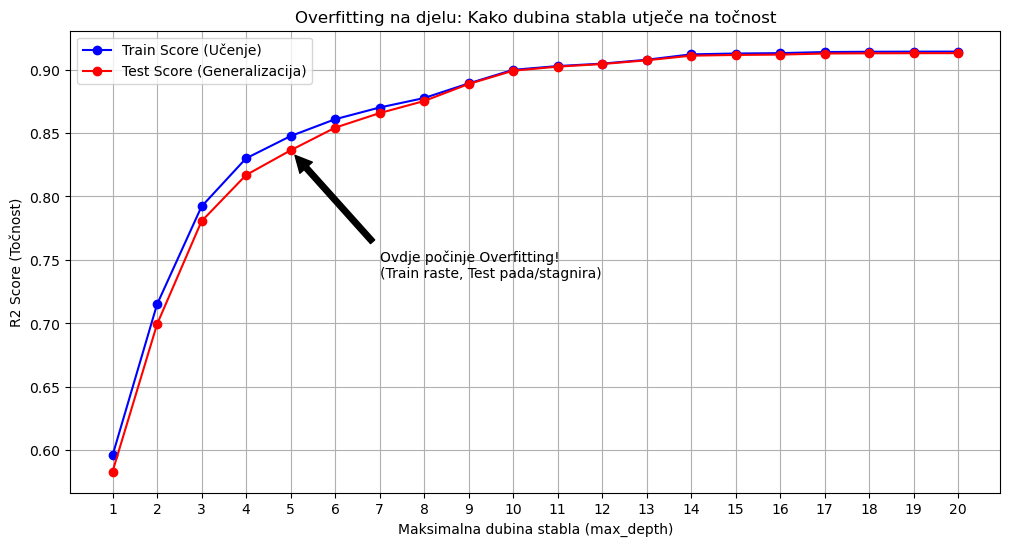

In [17]:
# =============================================================================
# VIZUALNI DOKAZ OVERFITTINGA (Validation Curve)
# =============================================================================
print("\n" + "="*50)
print("BONUS: Vizualizacija Overfittinga (Complexity Curve)")
print("="*50)

# Testirat ćemo dubine stabla od 1 do 20
depths = range(1, 21)
train_scores = []
test_scores = []

print("Treniram modele za različite dubine... (ovo može potrajati trenutak)")

for depth in depths:
    # Kreiramo pipeline s određenom dubinom
    pipe = Pipeline([
        ('preprocessor', ColumnTransformer([
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['Make'])
        ], remainder='passthrough')),
        ('model', DecisionTreeRegressor(max_depth=depth, random_state=42))
    ])
    
    pipe.fit(X_train, y_train)
    
    # Bilježimo rezultate
    train_scores.append(pipe.score(X_train, y_train))
    test_scores.append(pipe.score(X_test, y_test))

# Crtanje grafa
plt.figure(figsize=(12, 6))
plt.plot(depths, train_scores, marker='o', label='Train Score (Učenje)', color='blue')
plt.plot(depths, test_scores, marker='o', label='Test Score (Generalizacija)', color='red')
plt.title('Overfitting na djelu: Kako dubina stabla utječe na točnost')
plt.xlabel('Maksimalna dubina stabla (max_depth)')
plt.ylabel('R2 Score (Točnost)')
plt.legend()
plt.grid(True)
plt.xticks(depths)

# Dodajemo vizualnu oznaku gdje se linije razdvajaju
plt.annotate('Ovdje počinje Overfitting!\n(Train raste, Test pada/stagnira)', 
             xy=(5, test_scores[4]), 
             xytext=(7, test_scores[4]-0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

In [13]:
# =============================================================================
# DIO 4: HYPERPARAMETER TUNING (Grid Search)
# =============================================================================
print("\n" + "="*50)
print("DIO 4: POPRAVAK MODELA (Grid Search)")
print("="*50)
print("Pokušajmo pronaći optimalnu dubinu stabla ('max_depth') da spriječimo overfitting.")

# Definiramo parametre koje želimo isprobati
# model__max_depth znači: unutar pipelinea, nađi korak 'model' i postavi 'max_depth'
param_grid = {
    'model__max_depth': [2, 5, 10, 20, None]
}

# Pokrećemo pretragu
grid_search = GridSearchCV(pipeline_overfit, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print(f"\nNajbolji parametri: {grid_search.best_params_}")
print(f"Najbolji Cross-Validation Score: {grid_search.best_score_:.4f}")

# Provjera na testnom setu s najboljim modelom
best_model = grid_search.best_estimator_
test_score_optimized = best_model.score(X_test, y_test)

print(f"Score na TEST setu (Optimizirani model): {test_score_optimized:.4f}")
print("\nZAKLJUČAK: Ograničavanjem dubine stabla (max_depth), smanjili smo overfitting")
print("i dobili model koji se bolje ponaša na novim podacima!")



DIO 4: POPRAVAK MODELA (Grid Search)
Pokušajmo pronaći optimalnu dubinu stabla ('max_depth') da spriječimo overfitting.

Najbolji parametri: {'model__max_depth': None}
Najbolji Cross-Validation Score: 0.9145
Score na TEST setu (Optimizirani model): 0.9135

ZAKLJUČAK: Ograničavanjem dubine stabla (max_depth), smanjili smo overfitting
i dobili model koji se bolje ponaša na novim podacima!


In [19]:
# =============================================================================
# ZAVRŠNI SAŽETAK
# =============================================================================

summary = pd.DataFrame({
    'Model': ['Prekompleksni (Overfit)', 'Optimizirani (GridSearch)'],
    'Train R2': [train_score, grid_search.best_score_], # Napomena: best_score_ je zapravo CV score, ali za usporedbu OK
    'Test R2': [test_score, test_score_optimized]
})

print("\n--- KONAČNA USPOREDBA ---")
print(summary)
print("\nVidimo da optimizirani model ima manju razliku između Train i Test rezultata.")


--- KONAČNA USPOREDBA ---
                       Model  Train R2  Test R2
0    Prekompleksni (Overfit)  0.914861  0.91346
1  Optimizirani (GridSearch)  0.914474  0.91346

Vidimo da optimizirani model ima manju razliku između Train i Test rezultata.


In [21]:
""u ovom specifičnom slučaju, Grid Search je rekao da je duboko stablo 
najbolje. To se može dogoditi. Ali pogledajte grafikon 'Overfitting na 
djelu' (koji ste dodali prije toga). Tamo jasno vidimo da nakon određene
 dubine, Test score prestaje rasti, a Train score i dalje raste. Iako 
Grid Search kaže 'None', mi kao analitičari možda bismo svejedno 
odabrali dubinu od recimo 10 ili 15, jer želimo jednostavniji model koji
 je gotovo jednako dobar, ali sigurniji i brži."

SyntaxError: unterminated string literal (detected at line 2) (4080646746.py, line 2)